(faq:bulk_vs_surface_labelling)=

# Bulk vs. surface labelling

In the [reconstruction of the droplet](toolboxes:droplet_reconstruction:interactive), you need to set a key parameter: The `fluorescence type`. This essential parameter teklls the reconstruction whether you are working with a droplet that is labelled fluorescently in the bulk of the droplet or only on the surface. This is how the two different kinds of labelling techniques look like for an exemplary droplet:

| Bulk labelling | Surface labelling | Merged |
|---|---|---|
| ![bulk](./imgs/example_droplet_bulk.png) | ![surface](./imgs/example_droplet_surface.png) | ![merged](./imgs/example_droplet_merge.png) |

Since an essential step of the reconstruction is the retrieval of intensity values along the surface normal of the droplet, the used fit model needs to take into account the different labelling techniques. This is why you need to set the `fluorescence type` parameter correctly.

## Which one is better?

This raises an obvious follow-up question: Which labelling technique is better? The answer is: It depends. Both techniques have their advantages and disadvantages. In this notebook we examine how big the differences in the retrieved parameters are for the two different labelling techniques.

In [14]:
from aicsimageio import AICSImage
from napari_stress import measurements, reconstruction, plotting, utils, vectors
import napari
import numpy as np
from scipy.interpolate import griddata
import vedo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
viewer = napari.Viewer()

Invalid schema for package 'ome-types', please run 'npe2 validate ome-types' to check for manifest errors.


In [3]:
aics_image = AICSImage(r'C:\Users\johamuel\Desktop\Fileset_1143\HFE7700 labelled with Cy5_DSPE-streptavidin 790_RGD.czi')
channel_surface = aics_image.get_image_data("ZYX", C=0)
channel_bulk = aics_image.get_image_data("ZYX", C=1)

These are the reconstruction parameters we use:

In [4]:
reconstruction_parameters_surface = utils.import_settings(file_name='settings_reconstruction_surface.yaml')
reconstruction_parameters_bulk = utils.import_settings(file_name='settings_reconstruction_bulk.yaml')
measurement_settings = utils.import_settings(file_name='settings_measurement.yaml')
reconstruction_parameters_surface

{'edge_type': 'surface',
 'fit_type': 'fancy',
 'interpolation_method': 'linear',
 'n_points': 256,
 'n_smoothing_iterations': 15,
 'n_tracing_iterations': 1,
 'outlier_tolerance': 1.5,
 'remove_outliers': True,
 'resampling_length': 5.0,
 'sampling_distance': 1.0,
 'smoothing_sigma': 1.0,
 'target_voxelsize': 0.2868,
 'trace_length': 30.0,
 'return_intermediate_results': True,
 'voxelsize': array([0.47  , 0.1036, 0.1036])}

We now reconstruct the droplets and retrieve the relevant measurements for both labelling techniques.

In [5]:
reconstruction_results_surface = reconstruction.reconstruct_droplet(channel_surface, **reconstruction_parameters_surface)
reconstruction_results_bulk = reconstruction.reconstruct_droplet(channel_bulk, **reconstruction_parameters_bulk)

measurements_results_surface = measurements.comprehensive_analysis(reconstruction_results_surface[2][0], **measurement_settings)
measurements_results_bulk = measurements.comprehensive_analysis(reconstruction_results_bulk[2][0], **measurement_settings)

         mesh.points() -> mesh.vertices
         (silence this with vedo.core.warnings['points_getter']=False)
Error in PyGeodesicAlgorithmExact.geodesicDistances: zero-size array to reduction operation minimum which has no identity
Error in PyGeodesicAlgorithmExact.geodesicDistances: zero-size array to reduction operation minimum which has no identity


In [6]:
viewer.layers.clear()
viewer.add_image(channel_surface, name='Surface', colormap='green', blending='additive', scale=aics_image.physical_pixel_sizes)
viewer.add_image(channel_bulk, name='Bulk', colormap='magenta', blending='additive', scale=aics_image.physical_pixel_sizes)

viewer.add_points(reconstruction_results_surface[2][0], name='Reconstructed surface (surface)', size=0.5, face_color='white')
viewer.add_points(reconstruction_results_bulk[2][0], name='Reconstructed surface (bulk)', size=0.5, face_color='orange')

<Points layer 'Reconstructed surface (bulk)' at 0x1b7818f5d90>

## How different are the reconstructions?

To find out, we have to take a look at the results of the comprehensive stress analysis (for a more in-depth explanation of the retrieved properties, check out [this notebook](toolboxes:analyze_everything) or have a look at the [glossary]((glossary:spherical_harmonics))). Since the droplets in this example are suspended in water, we expect very little deformation. 

### Ellipsoidal approximation

We can check this by looking at the ellipsoidal expansion. We calculate the lengths of the fitted ellipsoid's major axes and compare them. This tells us that there is a minor difference in the ellipsoidal axis lengths of the reconstructed droplets.

In [7]:
axes_lengths_surface = np.sort(np.linalg.norm(measurements_results_surface[2][0][:, 1], axis=1))
axes_lengths_bulk = np.sort(np.linalg.norm(measurements_results_bulk[2][0][:, 1], axis=1))

difference = np.abs(axes_lengths_surface - axes_lengths_bulk)

print(f"Surface: {axes_lengths_surface}")
print(f"Bulk: {axes_lengths_bulk}")
print(f"Difference: {difference}")

Surface: [31.36702762 31.54559713 31.63272137]
Bulk: [31.2602302  31.35850851 31.53261161]
Difference: [0.10679742 0.18708862 0.10010976]


### Average distance to the droplet's center
We can retrieve the points after the spherical-harmonics expansion and calculate the average distance to the droplet's center.

In [8]:
points_spherical_harmonics_surface = measurements_results_surface[0][0]
points_spherical_harmonics_bulk = measurements_results_bulk[0][0]

# center points around origin (0,0,0)
points_surface_centered = points_spherical_harmonics_surface - points_spherical_harmonics_surface.mean(axis=0)
points_bulk_centered = points_spherical_harmonics_bulk - points_spherical_harmonics_bulk.mean(axis=0)

average_radius_surface = np.mean(np.linalg.norm(points_surface_centered, axis=1))
average_radius_bulk = np.mean(np.linalg.norm(points_bulk_centered, axis=1))

print(f"Average radius surface: {average_radius_surface}")
print(f"Average radius bulk: {average_radius_bulk}")

Average radius surface: 31.513480322817934
Average radius bulk: 31.38322495696798


### Pairwise distances

We can calculate the pairwise distances between the points on the droplet's surface after the spherical harmonics expansion and compare them. To do so, we need to circumvent the problem that we don't necessarily know which point corresponds to which in the respective other spherical harmonics expansion. To fix this, we center both pointclouds around the origin (0,0,0) and convert their coordinates into spherical coordinates. We then calculate the radius of the pointcloud (i.e., the distance of each point to the origin) and compare the two pointclouds' radii.

To obtain a set of sample locations, we sample the radii of both pointclouds on a regular grid in the $\theta$ (elevation/polar angle,  $\theta \in [0:\pi]$) and $\Phi$ (azimuth/equatorial angle $\Phi \in [-\pi:\pi]$) directions. We then calculate the difference of the two interpolation maps and plot them.

In [9]:
points_surface_spherical = vedo.transformations.cart2spher(points_surface_centered[:,2], points_surface_centered[:, 1], points_surface_centered[:, 0]).T
points_bulk_spherical = vedo.transformations.cart2spher(points_bulk_centered[:,2], points_bulk_centered[:, 1], points_bulk_centered[:, 0]).T

sample_grid_theta, sample_grid_phi = np.mgrid[0:np.pi:100j, -np.pi:np.pi:200j]
interpolated_radius_surface = griddata(points=points_surface_spherical[:, 1:],
                                       values=np.linalg.norm(points_surface_centered, axis=1),
                                       xi=(sample_grid_theta, sample_grid_phi))
interpolated_radius_bulk = griddata(points=points_bulk_spherical[:, 1:],
                                    values=np.linalg.norm(points_bulk_centered, axis=1),
                                    xi=(sample_grid_theta, sample_grid_phi))
difference = np.abs(interpolated_radius_surface - interpolated_radius_bulk)

We see that the pointwise distances between the two pointclouds are very small ($difference < 0.8$), whereas there is likely some distortion around the polar region. The averaged difference amounts to approximately $0.217, which is in agreement with the results from above.

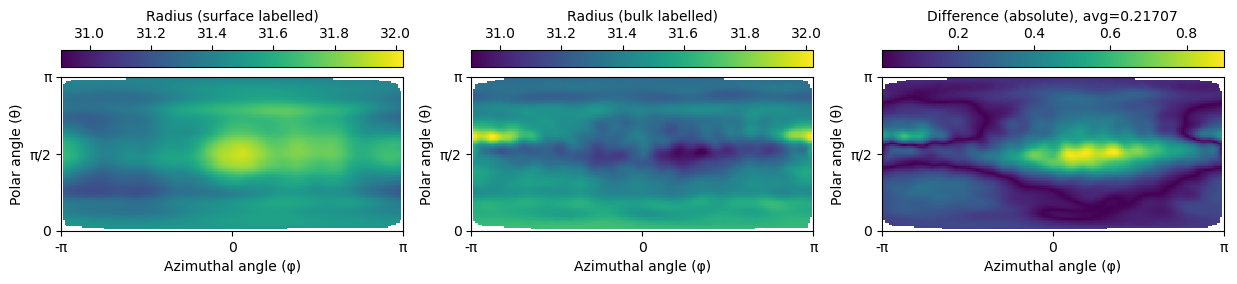

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 2.5))

# same contrast for all images
vmin = min([np.nanmin(interpolated_radius_surface), np.nanmin(interpolated_radius_bulk)])
vmax = max([np.nanmax(interpolated_radius_surface), np.nanmax(interpolated_radius_bulk)])

# plot angular map and set xticks to -np.pi to np.pi and yticks to 0 to np.pi
pcm1 = axes[0].pcolormesh(interpolated_radius_surface, cmap='viridis', vmin=vmin, vmax=vmax)
pcm2 = axes[1].pcolormesh(interpolated_radius_bulk, cmap='viridis', vmin=vmin, vmax=vmax)
pcm3 = axes[2].pcolormesh(difference, cmap='viridis')

fig.colorbar(pcm1, ax=axes[0], label='Radius (surface labelled)', location='top')
fig.colorbar(pcm2, ax=axes[1], label='Radius (bulk labelled)', location='top')
fig.colorbar(pcm3, ax=axes[2], label='Difference (absolute), avg={:.5f}'.format(np.nanmean(difference)), location='top')

for ax in axes:
    ax.set_xticks([0, 100, 200])
    ax.set_xticklabels(['-π', 0,  'π'])
    ax.set_xlabel('Azimuthal angle (φ)')
    ax.set_yticks([0, 50, 100])
    ax.set_yticklabels(['0', 'π/2', 'π'])
    ax.set_ylabel('Polar angle (θ)')

## Stress anisotropies

Despite the slight differences in the reconstructions, the big question is obviously: Does this translate into differences in the stress anisotropies? Let's have a look.

In [11]:
df_surface_over_time, df_surface_nearest_pairs, df_surface_all_pairs, df_surface_autocorrelations = utils.compile_data_from_layers(
    measurements_results_surface, n_frames=1, time_step=0)

df_bulk_over_time, df_bulk_nearest_pairs, df_bulk_all_pairs, df_bulk_autocorrelations = utils.compile_data_from_layers(
    measurements_results_bulk, n_frames=1, time_step=0)

In [12]:
difference_tissue = df_surface_over_time["stress_tissue_anisotropy"].values[0] - df_bulk_over_time["stress_tissue_anisotropy"].values[0]
difference_cell = df_surface_over_time["stress_cell_anisotropy"].values[0] - df_bulk_over_time["stress_cell_anisotropy"].values[0]
difference_total = df_surface_over_time["stress_total_anisotropy"].values[0] - df_bulk_over_time["stress_total_anisotropy"].values[0]

print('Difference tissue stress anisotropy: {:.4} kPa'.format(difference_tissue))
print('Difference cell stress anisotropy: {:.4} kPa'.format(difference_cell))
print('Difference total stress anisotropy: {:.4} kPa'.format(difference_total))

Difference tissue stress anisotropy: -0.0002139 kPa
Difference cell stress anisotropy: -0.08509 kPa
Difference total stress anisotropy: -0.08361 kPa


### Tissue stress distribution

Instead of only looking at the stress anisotropies (which take only into account the differences between the highest and lowest stresses), we can also have a look at the entire distributions of stresses in both labelling conditions. As a simpler way, we have a look at mean curvature distributions, from which anisotropic stresses are inferred.

In [30]:
mean_curvature_ellipsoid_surface = measurements_results_surface[3][1]['features']['mean_curvature']
mean_curvature_ellipsoid_bulk = measurements_results_bulk[3][1]['features']['mean_curvature']

# combine both into a dataframe with an extra columne indicating labelling type. Both variables are numpy arrays
df = pd.DataFrame(np.concatenate([mean_curvature_ellipsoid_surface, mean_curvature_ellipsoid_bulk]),
                  columns=['mean_curvature'])
df['labelling'] = np.concatenate([['Surface'] * len(mean_curvature_ellipsoid_surface),
                                  ['Bulk'] * len(mean_curvature_ellipsoid_bulk)])

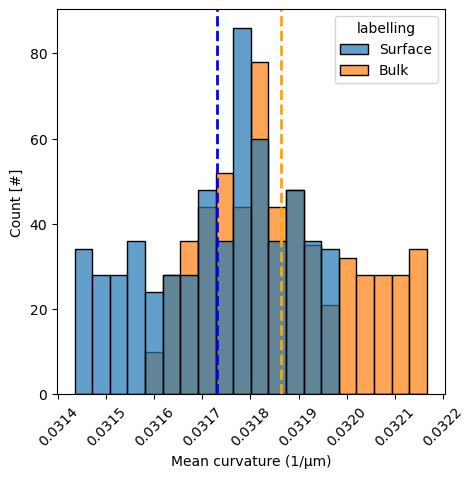

In [31]:

fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(df, x='mean_curvature', hue='labelling', alpha=0.7, ax=ax)

# put vertical line at each mean
ax.axvline(mean_curvature_ellipsoid_surface.mean(), color='blue', linestyle='--', linewidth=2)
ax.axvline(mean_curvature_ellipsoid_bulk.mean(), color='orange', linestyle='--', linewidth=2)
ax.set_xlabel('Mean curvature (1/µm)')
ax.set_ylabel('Count [#]')

# rotate the x-axis labels
_ = plt.xticks(rotation=45)

### Cell/Total anisotropic stress distributions

In a similar way, let's look at the mean curvature distributions, from which total and cell-scale anisotropic stresses are derived. We have a look at both the normal distribution as a histogram as well as the cumulative distribution function (CDF).

In [32]:
mean_curvature_droplet_surface = measurements_results_surface[4][1]['features']['mean_curvature']
mean_curvature_droplet_bulk = measurements_results_bulk[4][1]['features']['mean_curvature']

# combine both into a dataframe with an extra columne indicating labelling type. Both variables are numpy arrays
df = pd.DataFrame(np.concatenate([mean_curvature_droplet_surface, mean_curvature_droplet_bulk]),
                  columns=['mean_curvature'])
df['labelling'] = np.concatenate([['Surface'] * len(mean_curvature_droplet_surface),
                                  ['Bulk'] * len(mean_curvature_droplet_bulk)])

Text(0.5, 1.0, 'Cumulative distribution')

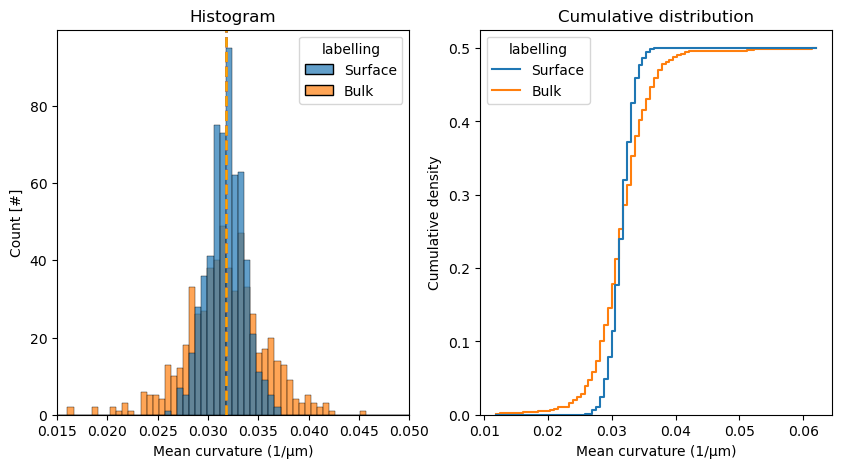

In [42]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
sns.histplot(df, x='mean_curvature', hue='labelling', alpha=0.7, ax=axes[0])
sns.histplot(df, x='mean_curvature', hue='labelling', cumulative=True, stat='density', ax=axes[1], fill=False, element='step')

# put vertical line at each mean
axes[0].axvline(mean_curvature_droplet_surface.mean(), color='blue', linestyle='--', linewidth=2)
axes[0].axvline(mean_curvature_droplet_bulk.mean(), color='orange', linestyle='--', linewidth=2)
axes[0].set_xlabel('Mean curvature (1/µm)')
axes[0].set_ylabel('Count [#]')
axes[0].set_xlim(0.015, 0.05)

axes[1].set_xlabel('Mean curvature (1/µm)')
axes[1].set_ylabel('Cumulative density')

# Titles
axes[0].set_title('Histogram')
axes[1].set_title('Cumulative distribution')